In [71]:
#imports
from os import listdir, getcwd, chdir
from os.path import isfile, join, dirname, realpath
import pandas as pd
from bs4 import BeautifulSoup

In [72]:
#functions to read in email files
res_frame = pd.DataFrame()
from os import listdir, getcwd, chdir
from os.path import isfile, join, dirname, realpath
import pandas as pd

def get_cwd():
    try:
        chdir(dirname(realpath(__file__)))
    except:
        chdir('/Users/nedei/Documents/School/QTW')
    active_dir = getcwd()
       
    return active_dir

def main():
    
    get_cwd()
    
    directories = [
        '/spam/',
        '/easy_ham/',
        '/easy_ham_2',
        '/hard_ham/',
        '/spam_2/'
        ]
    
    res_frame = pd.DataFrame()
        
    for d in directories:
        mypath = getcwd() + '/SpamAssassinMessages/' + d + '/'
        onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
    
        try:
            onlyfiles.remove('.DS_Store')
        except:
            pass
        
        for file in onlyfiles:
            with open(mypath + file, encoding='latin1') as f:
                lines = f.readlines()
                f.close()
                
            in_reply_count = 0
            sub_line_all_caps = 0
            attachments = 0
            subject_line = []
            n_lines = 0
            blank_lines = []
            
            #creation of dataframe with elements from emails
            for line in lines:
               n_lines += 1
               if "Subject: Re: " in line: #check if email is a reply to another email
                   in_reply_count += 1
               if "Subject: " in line: #see if subject line is all caps
                   s_line = line.strip().replace('Subject: ','')
                   subject = s_line
                   s_line = ''.join(e for e in s_line if e.isalnum())
                   num_upper = sum(1 for c in s_line if c.isupper())
                   ttl_chars = len(s_line)
                   if num_upper == ttl_chars:
                       sub_line_all_caps += 1
                   subject_line.append(s_line) #pull all subject lines
               if "content-type: multipart" in line.lower(): #check for attachments
                   attachments += 1
               if line == "\n": #remove blanklines from email to get a count of email length
                   blank_lines.append(n_lines)
               if "From:" in line: #pull from email address
                   f_line = line.strip().replace('From: ','')
                   fromline = f_line
            
                 
        
            temp_frame = pd.DataFrame({
                        'filename':file,
                        'is_spam':[1 if 'spam' in d else 0],
                        'in_reply': [1 if in_reply_count > 0 else 0], 
                        'subj_caps': [1 if sub_line_all_caps > 0 else 0], 
                        'attachments': [1 if attachments > 0 else 0], 
                        'body_lines': n_lines - len(blank_lines),
                        'Subject': subject,
                        'From': fromline
                        }, index=[0])
           
            res_frame = res_frame.append(temp_frame, ignore_index=True)
            
    res_frame.to_csv('output_file.csv', index=False)
    
    return res_frame


In [73]:
#run email loader
if __name__ == "__main__":
    res_frame = main()
    pass       

In [74]:
#check dataframe to make sure it looks like we want it
res_frame.head()

,filename,is_spam,in_reply,subj_caps,attachments,body_lines,Subject,From
0,00001.7848dde101aa985090474a91ec93fcf0,1,0,0,0,120,Life Insurance - Why Pay More?,12a1mailbot1@web.de
1,00002.d94f1b97e48ed3b553b3508d116e6a09,1,0,0,0,59,[ILUG] Guaranteed to lose 10-12 lbs in 30 days...,"""Slim Down"" <taylor@s3.serveimage.com>"
2,00003.2ee33bc6eacdb11f38d052c44819ba6c,1,0,0,0,43,Guaranteed to lose 10-12 lbs in 30 days ...,"""Slim Down"" <sabrina@mx3.1premio.com>"
3,00004.eac8de8d759b7e74154f142194282724,1,1,0,0,90,Re: Fw: User Name & Password to Membership To ...,Account Services <wsup@playful.com>
4,00005.57696a39d7d84318ce497886896bf90d,1,0,0,0,55,[ILUG-Social] re: Guaranteed to lose 10-12 lbs...,"""Slim n Trim"" <yenene@mx2.1premio.com>"


In [75]:
#break of subject line and from email address into list for vectorization
subject_lines = res_frame['Subject'].tolist()
from_lines = res_frame['From'].tolist()

In [76]:
#vectorize NLP components for clustering
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words={'english'})
x = vectorizer.fit_transform(subject_lines)
y = vectorizer.fit_transform(from_lines)

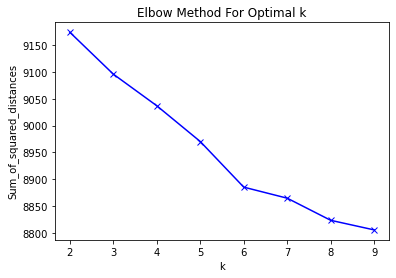

In [77]:
#use k-means clustering to find ideal number of clusters using elbow method.
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
Sum_of_squared_distances = []
K = range(2,10)
for k in K:
   km = KMeans(n_clusters=k, max_iter=40, n_init=10,random_state = 0)
   km = km.fit(x)
   Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [78]:
#elbow looks to be at 6 so we can assume that 6 is the optimum number of clusters
#cluster subject lines into 6 clusters based on similarity of string contents
true_k = 6
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=40, n_init=10,random_state = 0)
model.fit(x)
labels=model.labels_
subject_cluster=pd.DataFrame(list(zip(subject_lines,labels)),columns=['subject_lines','subject_cluster'])
print(subject_cluster)

                                          subject_lines  subject_cluster
0                        Life Insurance - Why Pay More?                1
1     [ILUG] Guaranteed to lose 10-12 lbs in 30 days...                1
2     Guaranteed to lose 10-12 lbs in 30 days       ...                1
3     Re: Fw: User Name & Password to Membership To ...                1
4     [ILUG-Social] re: Guaranteed to lose 10-12 lbs...                3
...                                                 ...              ...
9348             Preferred Non-Smoker Rates for Smokers                1
9349  How to get 10,000 FREE hits per day to any web...                1
9350                                Cannabis Difference                1
9351                              [ILUG] WILSON  KAMELA                3
9352                              [ILUG] WILSON  KAMELA                3

[9353 rows x 2 columns]


Cluster: 0


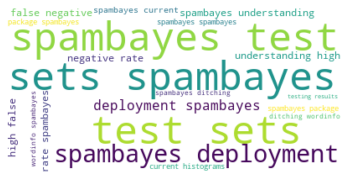

Cluster: 1


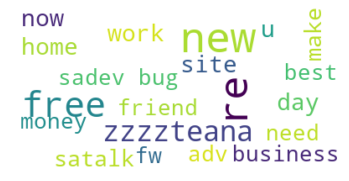

Cluster: 2


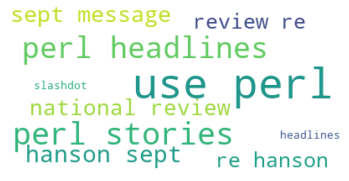

Cluster: 3


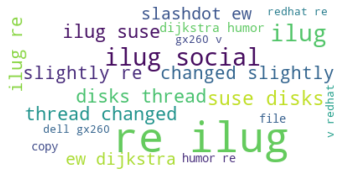

Cluster: 4


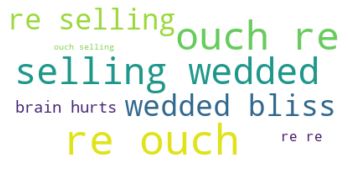

Cluster: 5


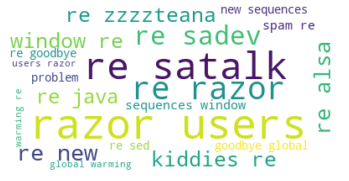

In [93]:
#Create wordcloud for subject lines
from wordcloud import WordCloud
result={'subject_cluster':labels,'subject_lines':subject_lines,}
result=pd.DataFrame(result)
for k in range(0,true_k):
   s=result[result.subject_cluster==k]
   text=s['subject_lines'].str.cat(sep=' ')
   text=text.lower()
   text=' '.join([word for word in text.split()])
   wordcloud = WordCloud(max_font_size=50, max_words=20, background_color="white").generate(text)
   print('Cluster: {}'.format(k))
   #print('Titles')
   titles=subject_cluster[subject_cluster.subject_cluster==k]['subject_lines']         
   #print(titles.to_string(index=False))
   plt.figure()
   plt.imshow(wordcloud, interpolation="bilinear")
   plt.axis("off")
   plt.show()

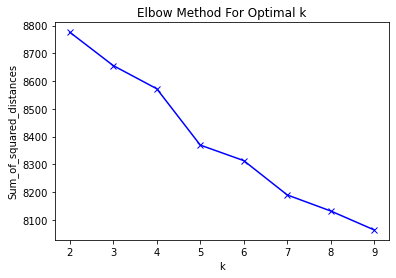

In [94]:
#identifying likely real k for KMeans for from line information
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
Sum_of_squared_distances = []
K = range(2,10)
for k in K:
   km = KMeans(n_clusters=k, max_iter=40, n_init=10,random_state = 0)
   km = km.fit(y)
   Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [95]:
#elbow looks to be at k = 5. Creation of From_line clusters using this metric.
true_k = 5
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=40, n_init=10,random_state = 0)
model.fit(y)
labels=model.labels_
from_cluster=pd.DataFrame(list(zip(from_lines,labels)),columns=['from_lines','from_cluster'])
print(from_cluster)

                                             from_lines  from_cluster
0                                   12a1mailbot1@web.de             0
1                "Slim Down" <taylor@s3.serveimage.com>             0
2                 "Slim Down" <sabrina@mx3.1premio.com>             0
3                   Account Services <wsup@playful.com>             0
4                "Slim n Trim" <yenene@mx2.1premio.com>             0
...                                                 ...           ...
9348                          "IQ - TBA" <tba@insiq.us>             0
9349                               Mike <raye@yahoo.lv>             0
9350                   "Mr. Clean" <cweqx@dialix.oz.au>             0
9351  "wilsonkamela400@netscape.net" <wilsonkamela50...             0
9352  "wilsonkamela400@netscape.net" <wilsonkamela50...             0

[9353 rows x 2 columns]


Cluster: 0


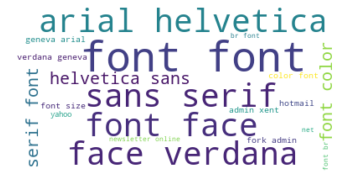

Cluster: 1


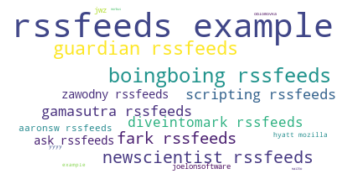

Cluster: 2


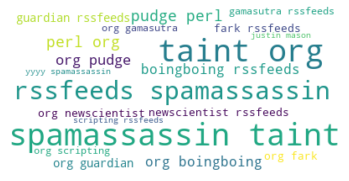

Cluster: 3


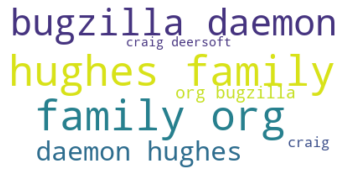

Cluster: 4


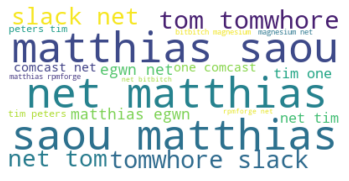

In [97]:
#Create word cloud of from line information
from wordcloud import WordCloud
result={'from_cluster':labels,'from_lines':from_lines,}
result=pd.DataFrame(result)
for k in range(0,true_k):
   s=result[result.from_cluster==k]
   text=s['from_lines'].str.cat(sep=' ')
   text=text.lower()
   text=' '.join([word for word in text.split()])
   wordcloud = WordCloud(max_font_size=50, max_words=20, background_color="white").generate(text)
   print('Cluster: {}'.format(k))
   #print('Titles')
   titles=from_cluster[from_cluster.from_cluster==k]['from_lines']         
   #print(titles.to_string(index=False))
   plt.figure()
   plt.imshow(wordcloud, interpolation="bilinear")
   plt.axis("off")
   plt.show()

In [98]:
#quick visual inspection of the data to look at makeup of spam in each of the created clusters
cluster_frame = res_frame.join(subject_cluster)
cluster_frame = cluster_frame.drop(['Subject','subject_lines'],axis = 1)
cluster_frame = cluster_frame.join(from_cluster)
cluster_frame = cluster_frame.drop(['From','from_lines'],axis = 1)
print(cluster_frame.groupby(['subject_cluster','is_spam']).count())
print(cluster_frame.groupby(['from_cluster','is_spam']).count())

                         filename  in_reply  subj_caps  attachments  \
subject_cluster is_spam                                               
0               0             224       224        224          224   
1               0            3078      3078       3078         3078   
                1            2254      2254       2254         2254   
2               0             173       173        173          173   
3               0             663       663        663          663   
                1              98        98         98           98   
4               0             129       129        129          129   
5               0            2687      2687       2687         2687   
                1              47        47         47           47   

                         body_lines  from_cluster  
subject_cluster is_spam                            
0               0               224           224  
1               0              3078          3078  
          

In [61]:
#one hot encode of cluster variables, all others are already one hot encoded or continuous
subject_cluster = pd.get_dummies(cluster_frame.subject_cluster, prefix = 'subject_cluster')
df_onehot = pd.concat((cluster_frame,subject_cluster),axis = 1)
from_cluster = pd.get_dummies(cluster_frame.from_cluster, prefix = 'from_cluster')
df_onehot = pd.concat((df_onehot,from_cluster),axis = 1)
target = df_onehot['is_spam']
data = df_onehot.drop(['filename','is_spam','subject_cluster','from_cluster'],axis = 1)
data.head()

,in_reply,subj_caps,attachments,body_lines,subject_cluster_0,subject_cluster_1,subject_cluster_2,subject_cluster_3,subject_cluster_4,subject_cluster_5,from_cluster_0,from_cluster_1,from_cluster_2,from_cluster_3,from_cluster_4
0,0,0,0,120,0,1,0,0,0,0,1,0,0,0,0
1,0,0,0,59,0,1,0,0,0,0,1,0,0,0,0
2,0,0,0,43,0,1,0,0,0,0,1,0,0,0,0
3,1,0,0,90,0,1,0,0,0,0,1,0,0,0,0
4,0,0,0,55,0,0,0,1,0,0,1,0,0,0,0


In [62]:
#looking for optimized GaussianNB var smoothing parameter.
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
import numpy as np

scaler = StandardScaler()
cv = StratifiedKFold(n_splits = 10, random_state = 0, shuffle = True)

var = [.25,.5,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
for x in var:
    # define the pipeline
    steps = list()
    steps.append(('scaler', scaler))
    steps.append(('model', GaussianNB(var_smoothing=x)))
    pipeline = Pipeline(steps=steps)

    #Modeling with pipeline and scoring with cross_validate()
    scores = cross_validate(pipeline, data, target, scoring=['roc_auc','accuracy','precision','recall'],
                             cv=cv, return_train_score=False)
    columns = ['Var','Prec','AUC']
    df3 = []
    prec = np.mean(scores['test_precision'])
    auc = np.mean(scores['test_roc_auc'])
    rec = np.mean(scores['test_recall'])
    f1 = 2*((prec*rec)/(prec+rec))
    values = [x,prec,auc,rec]
    zipped = zip(columns,values)
    dictionary = dict(zipped)
    df3.append(dictionary)
    
    
    print('When VAR =',x)
    print('   Mean Precision: ',prec)
    print('   Mean AUC: ',auc)
    print('   Mean Recall: ',rec)
    print('   Mean F1: ',f1)
    print('   Mean Time per Split: ',np.mean(scores['fit_time'])+np.mean(scores['score_time']))
    print(' ')

When VAR = 0.25
   Mean Precision:  0.5718870467124106
   Mean AUC:  0.8795373043164803
   Mean Recall:  0.9599738493723852
   Mean F1:  0.7167708387124053
   Mean Time per Split:  0.015110158920288086
 
When VAR = 0.5
   Mean Precision:  0.5607134960008139
   Mean AUC:  0.8777970709440959
   Mean Recall:  0.9729044630404463
   Mean F1:  0.7114166334974781
   Mean Time per Split:  0.014676094055175781
 
When VAR = 1
   Mean Precision:  0.5349029239811846
   Mean AUC:  0.8771801159130407
   Mean Recall:  0.9824895397489539
   Mean F1:  0.6926837191490205
   Mean Time per Split:  0.013502120971679688
 
When VAR = 2
   Mean Precision:  0.5817380155770397
   Mean AUC:  0.8763935945494075
   Mean Recall:  0.949973849372385
   Mean F1:  0.7215925065674416
   Mean Time per Split:  0.0158174991607666
 
When VAR = 3
   Mean Precision:  0.582392926499114
   Mean AUC:  0.8755681182258062
   Mean Recall:  0.9495571827057183
   Mean F1:  0.7219757134274862
   Mean Time per Split:  0.015052914619445

C:\Users\nedei\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nedei\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nedei\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


When VAR = 15
   Mean Precision:  0.6666666666666667
   Mean AUC:  0.8749983024077059
   Mean Recall:  0.004168410041841004
   Mean F1:  0.00828501706120985
   Mean Time per Split:  0.01559116840362549
 


C:\Users\nedei\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [63]:
#creation of test_train split for final model
from sklearn.model_selection import train_test_split
from sklearn import metrics as mt
from sklearn.metrics import plot_confusion_matrix, roc_auc_score

X_dev_train,X_dev_test,Y_train,Y_test = train_test_split(data,target,test_size=0.20,random_state=0)
X_train = scaler.fit_transform(X_dev_train)
X_test = scaler.transform(X_dev_test)

VAR Smoothing: 15 AUC: 0.5956114105102412 Precision: 0.8095238095238095 ACC: 0.780331373597007 F1 Score: 0.33170731707317075


C:\Users\nedei\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


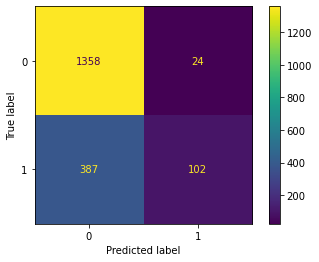

In [64]:
#two possible ideal VAR values, Look at VAR smoothing 6 confusion matrix to see what it is actually predicting.
clf_gnb = GaussianNB(var_smoothing = 6)
clf_gnb.fit(X_train,Y_train.values.ravel())
yhat = clf_gnb.predict(X_test)
acc = mt.accuracy_score(Y_test,yhat)
prec = mt.precision_score(Y_test,yhat)
auc = roc_auc_score(Y_test,yhat)
recall = mt.recall_score(Y_test,yhat)
f1 = 2*((prec*recall)/(prec+recall))
print('VAR Smoothing:',x,'AUC:',auc,'Precision:',prec,'ACC:',acc,'F1 Score:',f1)
plot_confusion_matrix(clf_gnb,X_test,Y_test)

VAR Smoothing: 15 AUC: 0.8447257908428257 Precision: 0.5951742627345844 ACC: 0.814537680384821 F1 Score: 0.7190283400809715


C:\Users\nedei\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


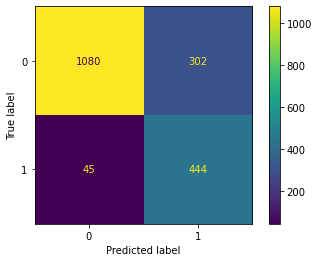

In [55]:
#looking at VAR smoothing of 5 to see how this model predicts.
clf_gnb = GaussianNB(var_smoothing = 5)
clf_gnb.fit(X_train,Y_train.values.ravel())
yhat = clf_gnb.predict(X_test)
acc = mt.accuracy_score(Y_test,yhat)
prec = mt.precision_score(Y_test,yhat)
auc = roc_auc_score(Y_test,yhat)
recall = mt.recall_score(Y_test,yhat)
f1 = 2*((prec*recall)/(prec+recall))
print('VAR Smoothing:',x,'AUC:',auc,'Precision:',prec,'ACC:',acc,'F1 Score:',f1)
plot_confusion_matrix(clf_gnb,X_test,Y_test)

#### Looking at how the two models predict we are going to go with VAR smoothing of 6. While this will allow more possible spam throught the system, it will limit the amount of time spent looking in the spam folder for important emails.

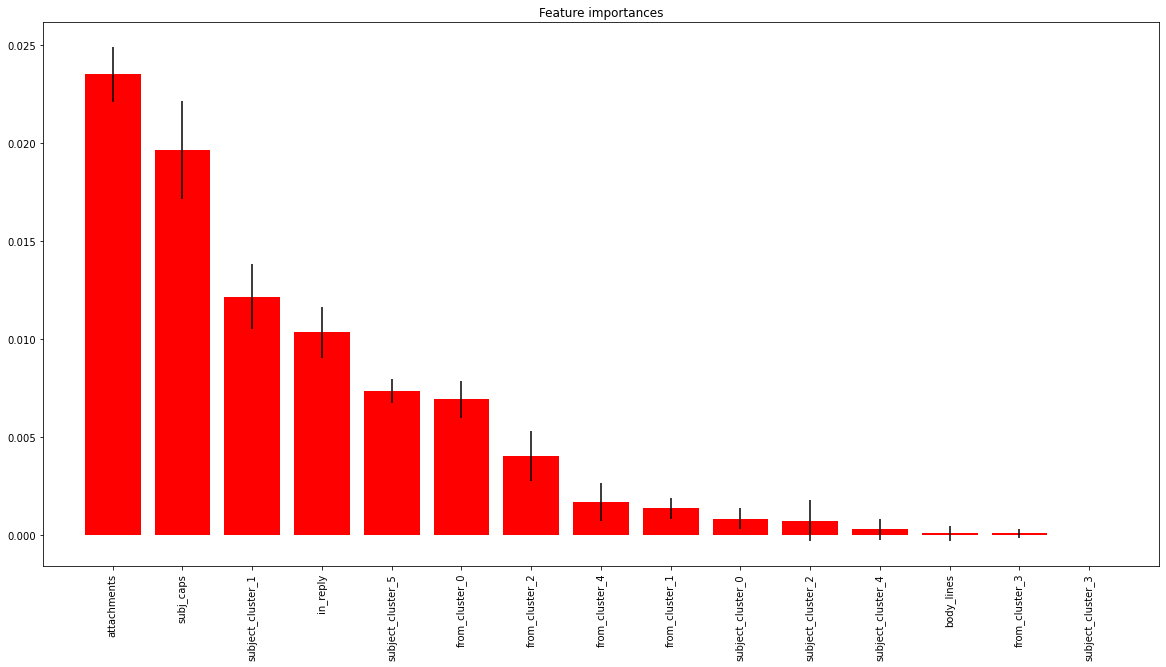

In [67]:
#looking at feature importance in the model to determine possible areas of improvement for future features.
features = list(data.columns.values)


from sklearn.inspection import permutation_importance

imps = permutation_importance(clf_gnb, X_test, Y_test)
importances = imps.importances_mean
std = imps.importances_std
indices = np.argsort(importances)[::-1]

# Print the feature ranking

featureorder = []

for f in range(X_test.shape[1]):
    featureorder.append(features[indices[f]])
featurecount = len(featureorder)
plt.figure(figsize=(20, 10))
plt.title("Feature importances")
plt.bar(range(X_test.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X_test.shape[1]), [features[indices[i]] for i in range(featurecount)],rotation = 90)
plt.xlim([-1, X_test.shape[1]])
plt.show()